# Kalman Filtering: 2D Kinematics

Here we'll look at a more realistic model, in which a target moves through two-dimensional space. We suppose the velocity of the target is subject to random accelerations, and that we get noisy measuremens of the target position.

In [118]:
import numpy as np
import matplotlib.pyplot as plt

DELTA = 0.1
Q = 1*np.diag([0, 0, 1, 1])
R = 2*np.eye(2)

F = np.eye(4)
F[0,2] = DELTA
F[1,3] = DELTA

H = np.zeros([2,4])
H[0,0] = 1
H[1,1] = 1

Let's generate a trajectory through 2D space according to this model.

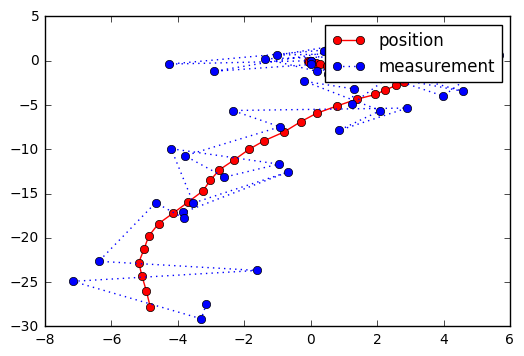

In [120]:
T = 50
x = np.zeros([4,T])
y = np.zeros([2,T])

for t in range(1,T):
    x[:,t] = F@x[:,t-1] + np.sqrt(Q)@np.random.randn(4)
    y[:,t] = H@x[:,t] + np.sqrt(R)@np.random.randn(2)

plt.plot(x[0,:],x[1,:],'ro-',label='position')
plt.plot(y[0,:],y[1,:],'bo:',label='measurement')
plt.legend()
plt.show()

Now, let's run the Kalman filter. We'll only plot the update iterates for simplicity.

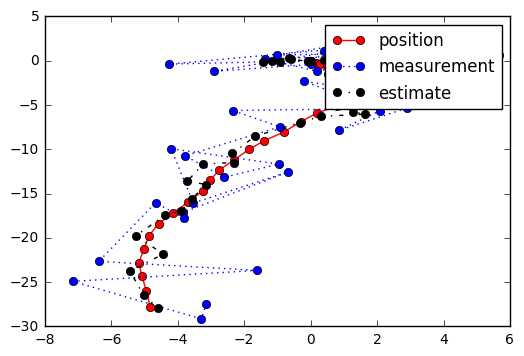

In [122]:
x_p = np.zeros([4,T])
x_m = np.zeros([4,T])
Sigma_p = np.zeros([4,4,T])
Sigma_m = np.zeros([4,4,T])
Sigma_m[:,:,0] = np.eye(4)

for t in range(1,T):
    #time update
    x_p[:,t] = F@x_m[:,t-1]
    Sigma_p[:,:,t] = F@Sigma_m[:,:,t-1]@F.T + Q
    
    #Kalman gain
    K = Sigma_p[:,:,t]@H.T@np.linalg.inv(H@Sigma_p[:,:,t]@H.T + R)
    
    #measurement update
    x_m[:,t] = x_p[:,t] + K@(y[:,t] - H@x_p[:,t])
    Sigma_m[:,:,t] = Sigma_p[:,:,t] - K@H@Sigma_p[:,:,t]

plt.plot(x[0,:],x[1,:],'ro-',label='position')
plt.plot(y[0,:],y[1,:],'bo:',label='measurement')
plt.plot(x_m[0,:],x_m[1,:],'ko-.',label='estimate')
plt.legend()
plt.show()

How well are we doing? A neat fact is that the Kalman filter tracks the velocity, even though we don't measure it directly. We'll measure the position and velocity error by computing the trace of the measurement update covariance matrix. This estimate isn't perfect, and certainly not as good as it would be if we could measure the velocity directly, but the Kalman filter "automagically" incorporates the kinematics to find the best possible estimate.

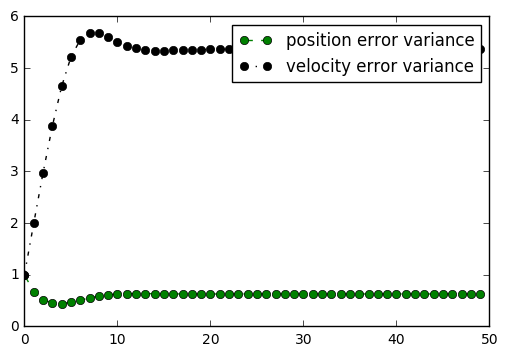

In [125]:
pos_e = np.trace(Sigma_m[0:1,0:1,:])
vel_e = np.trace(Sigma_m[2:3,2:3,:])

plt.plot(np.arange(0,T),pos_e,'go--',label='position error variance')
plt.plot(np.arange(0,T),vel_e,'ko-.',label='velocity error variance')
plt.legend()
plt.show()

## Extended Kalman Filtering

Let's suppose now that we get access to a measurement that gives the *radial* position and velocity. This is a good model for radar measurements. This measurement model is non-linear, so we'll need to use both the non-linear measurements and the Jacobian of the measurement model at the operating point.

In [194]:
DELTA = 0.1
Q = 1*np.diag([0, 0, 1, 1])
R = 0.1*np.eye(3)

F = np.eye(4)
F[0,2] = DELTA
F[1,3] = DELTA

def measurement(x):
    #x must be a 4D tuple; i won't error check here!
    y1 = np.sqrt(x[0]**2 + x[1]**2) #range
    y2 = np.arctan2(x[1],x[0]) #bearing
    y3 = (x[0]*x[2] + x[1]*x[3])/y1 #radial velocity
    
    return np.array([y1, y2, y3])

def Jacobian(x):
    H = np.zeros([3,4])
    r = np.sqrt(x[0]**2 + x[1]**2)
    H[0,0] = x[0]/r
    H[0,1] = x[1]/r
    H[1,0] = -x[1]/r**2
    H[1,1] = x[0]/r**2
    H[2,0] = x[1]*(x[2]*x[1] - x[3]*x[0])/r**3
    H[2,1] = x[0]*(x[2]*x[1] - x[3]*x[0])/r**3
    H[2,2] = x[0]/r
    H[2,3] = x[1]/r
    
    return H

Let's generate a sample trajectory. We will make sure not to start at the origin. Can you figure out why?

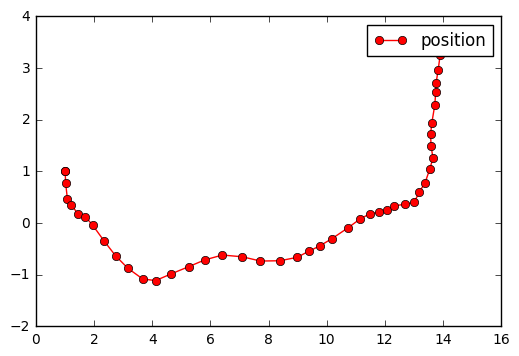

In [197]:
T = 50
x = np.zeros([4,T])
x[:,0] = [1,1,0,0]
y = np.zeros([3,T])

for t in range(1,T):
    x[:,t] = F@x[:,t-1] + np.sqrt(Q)@np.random.randn(4)
    y[:,t] = measurement(x[:,t]) + np.sqrt(R)@np.random.randn(3)

plt.plot(x[0,:],x[1,:],'ro-',label='position')
#plt.plot(y[0,:],y[1,:],'bo:',label='measurement')
plt.legend()
plt.show()

Now, let's run the EKF, which requires the use of the linearized dynamics. Again, we will avoid initializing our estimate at the origin.

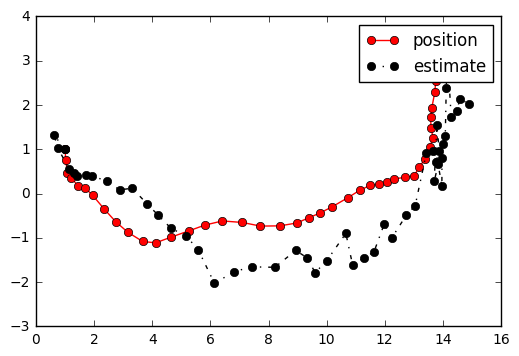

In [198]:
x_p = np.zeros([4,T])
x_m = np.zeros([4,T])
x_m[:,0] = [1,1,0,0]

Sigma_p = np.zeros([4,4,T])
Sigma_m = np.zeros([4,4,T])
Sigma_m[:,:,0] = np.eye(4)

for t in range(1,T):
    #time update
    x_p[:,t] = F@x_m[:,t-1]
    Sigma_p[:,:,t] = F@Sigma_m[:,:,t-1]@F.T + Q
    
    #Kalman gain
    J = Jacobian(x_p[:,t])
    K = Sigma_p[:,:,t]@J.T@np.linalg.inv(J@Sigma_p[:,:,t]@J.T + R)
    
    #measurement update
    x_m[:,t] = x_p[:,t] + K@(y[:,t] - measurement(x_p[:,t]))
    Sigma_m[:,:,t] = Sigma_p[:,:,t] - K@J@Sigma_p[:,:,t]

plt.plot(x[0,:],x[1,:],'ro-',label='position')
#plt.plot(y[0,:],y[1,:],'bo:',label='measurement')
plt.plot(x_m[0,:],x_m[1,:],'ko-.',label='estimate')
plt.legend()
plt.show()